In [1]:
import sys
sys.path.insert(1, '/home/elinfi/MasterCode/clustering/class/')

In [2]:
import time
import numpy as np
import cooltools.lib.plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time
from k_medoids import KMedoids
from cluster_statistics import ClusterStatistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix


In [3]:
# globally set font sizes
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In the comparison I use the merged wild type and cancer data. The Hi-C data is balanced using the built in ICE method in the cooler package. 

In [5]:
# get path to multi resolution hic data
path_wt = '/home/elinfi/coolers/HiC_wt_merged.mcool'
path_cancer = '/home/elinfi/coolers/HiC_cancer_merged.mcool'

resolution = 32000
region = 'chr4:5M-7M' # region of genome
balance = True

# create objects of class
wt = DataPreparation(path_wt, resolution, region, balance)
cancer = DataPreparation(path_cancer, resolution, region, balance)

# get the matrix size
print(f"Matrix size: {wt.matrix.shape}")

Matrix size: (63, 63)


To start with I plot the two created contact matrices for the given resolution and region.

# Her må det legges til riktig label på plottene

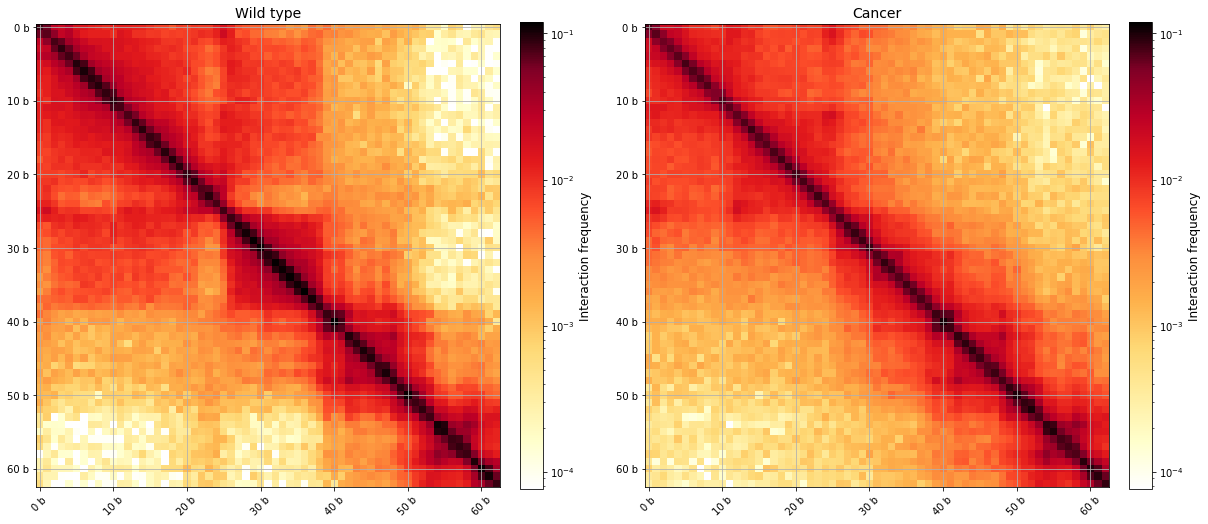

In [6]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

norm = mpl.colors.LogNorm()
#norm = None

ax = axs[0]
im = ax.matshow(wt.matrix,
                norm=norm,
                cmap='fall',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interaction frequency', ax=ax)
ax.grid(b=True)
ax.set(title='Wild type')
format_ticks(ax)

ax = axs[1]
im = ax.matshow(cancer.matrix,
                norm=norm,
                cmap='fall',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interaction frequency', ax=ax)
ax.grid(b=True)
ax.set(title='Cancer')
format_ticks(ax)

## Relative difference
Calculate the relative difference between the two Hi-C contact matrices.

In [7]:
relative_diff = wt.relative_difference(cancer)

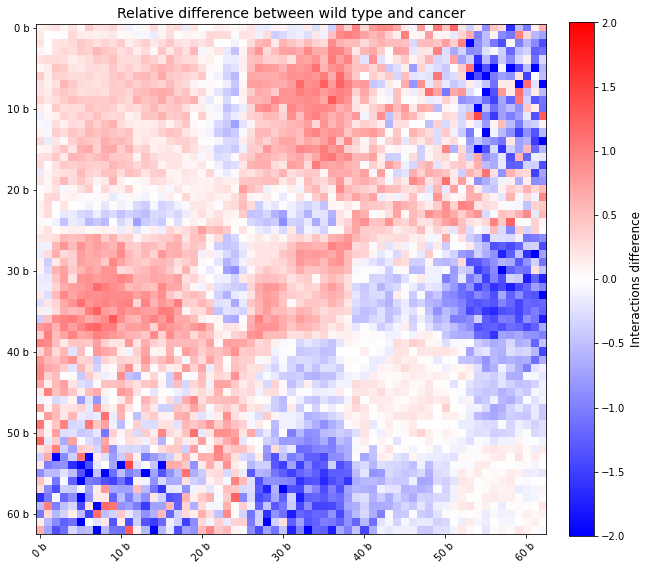

In [8]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(relative_diff))
im = ax.matshow(relative_diff,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title="Relative difference between wild type and cancer")
format_ticks(ax)

White indicates that the interaction frequency is the same in both the wild type and the cancer data. Red colors indicates higher interaction frequency in the wild type data, whereas blue indicates higher interaction frequency in the cancer data.

## Subtraction
Calculate the difference between the two interaction matrices by subtraction and visualize it.

In [9]:
subtract_diff = wt.subtract(cancer)

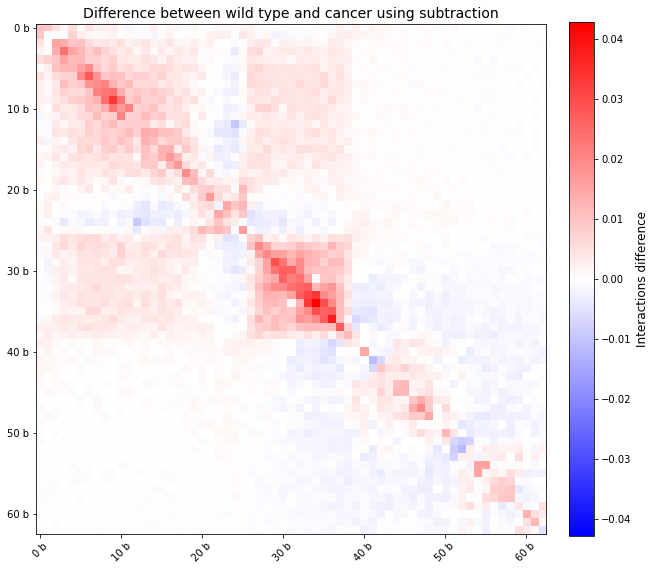

In [10]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(subtract_diff))
im = ax.matshow(subtract_diff,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title='Difference between wild type and cancer using subtraction')
plt.savefig('../../Figures/sub_002_001.png')
format_ticks(ax)

White indicates that the interaction frequency is the same in both the wild type and the cancer data. Red colors indicates higher interaction frequency in the wild type data, whereas blue indicates higher interaction frequency in the cancer data.

## Division
Calculate the difference between the two interaction matrices by division and visualize it.

In [11]:
### create distance matrix
dissimilarity = DissimilarityMatrix(diff_mat, scaler=None)

# interactions difference
start = time()
interactions_dist = dissimilarity.scipy_dist(metric='interactions_dist', col1=0, col2=3)
end = time()
print(f'Time interactions_dist: {end - start}')

# diagonal distance
start = time()
diagonal_dist = dissimilarity.scipy_dist(metric='diagonal_dist', col1=0, col2=3)
end = time()
print(f'Time diagonal_dist: {end - start}')
"""
# manhattan distance
start = time()
manhattan_dist = dissimilarity.scipy_dist(metric='manhattan')
end = time()
print(f'Time manhattan_dist: {end - start}')
"""
# manhattan distance
start = time()
euclidean_dist = dissimilarity.scipy_dist(metric='minkowski', col1=0, col2=2, p=1)/(2*dissimilarity.n)
end = time()
print(f'Time manhattan_dist: {end - start}')

# manhattan distance
start = time()
euclidean_dist = dissimilarity.scipy_dist(metric='diag_3d_dist', col1=0, col2=3)
end = time()
print(f'Time manhattan_dist: {end - start}')

NameError: name 'diff_mat' is not defined

In [ ]:
# calculate weighted distance matrix
w1 = 0
w2 = 1
w3 = 0
w4 = 0

#dist_mat = w1*interactions_dist + w2*diagonal_dist + w3*manhattan_dist + w4*euclidean_dist
dist_mat = w1*interactions_dist + w2*diagonal_dist

In [ ]:
### calculate kmedoids clusters
medoids = 2
random_state = 19

n = dissimilarity.n
triu_nan_idx = dissimilarity.triu_nan_idx

# find clusters using k-medoids
kmedoids = KMedoids(dist_mat)
cluster_result = kmedoids.clusters(medoids=medoids, random_state=random_state)
labels_mat = kmedoids.labels4plotting_nan(n, triu_nan_idx)


In [ ]:
# create discrete colormap
cmap = plt.cm.cool
bounds = np.linspace(0, medoids, medoids+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [ ]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

ax = axs[0]
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='IF difference', ax=ax)
ax.grid(b=True)
ax.set(title=region)
format_ticks(ax)

ax = axs[1]
im = ax.matshow(labels_mat,
                norm=norm,
                cmap=cmap,
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.grid(b=True)
ax.set(title='Weighted distance')
plt.savefig(f"../Figures/w1_{w1:.2f}_interactions_w2_{w2:.2f}_diag.png")
format_ticks(ax)

In [ ]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

ax = axs
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                #norm=mpl.colors.LogNorm(),
                cmap='bwr',
                vmin=-vmax,
                vmax=vmax)
plt.colorbar(im, fraction=0.04, pad=0.1, label='difference in interactions', ax=ax)

im = ax.contour(labels_mat,
                norm=norm,
                cmap='cool',
                levels=bounds,
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.set(title=region)
ax.set_facecolor('xkcd:green')

In [ ]:
stats = ClusterStatistics(medoids, cluster_result.labels, dissimilarity.X)
mean_list = stats.cluster_mean('diagonal_dist')
print(mean_list)